# WHVI regression on a toy example

This notebook illustrates the use of WHVI through a univariate regression problem. The goal is to approximately match the performance of the method to a similar example from the paper (see section 3.1).

TODO list:
* re-do the code to support CUDA,
* use 500/50000 epochs everywhere.

In [1]:
# Reproducibility
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0);

# Optimization related hyperparameters and settings
lambda0 = 0.001
gamma = 0.0005
p = 0.3

# device = torch.device("cuda")
device = torch.device("cpu")

## Creating the synthetic dataset

We first define our data generating process which we then sample from to create the synthetic dataset.
We know that $y = f(x) + \epsilon$ where $\epsilon \sim \mathrm{N}(0, \exp(-3))$, but the authors do not explicitly say what function $f$ is.
For this reason, we define a polynomial that is similar to it and see if we observe a similar pattern.
The polynomial coefficients are chosen based on observed extrema in the plot.

In [2]:
from torch.utils.data import Dataset, DataLoader

xs_poly = [-2.0, -1.5, -0.8, 0.0, 0.5, 1.4, 2.0, 2.7, 3.0]
ys_poly = [1.2, 1.5, 2.0, 0.5, -0.5, 1.2, 0.0, 1.0, 1.3]
vmat = np.vander(xs_poly, len(xs_poly))
coef = np.linalg.solve(vmat, ys_poly)
def f(x): return np.polyval(coef, x)

n = 128
x = np.random.rand(n) * 3 - 1
x = x[np.where((x < 0.6) | (x > 1.4))]
y = f(x) + np.random.randn(len(x)) * np.sqrt(np.exp(-3))
x = x.reshape(-1, 1).astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

class ToyDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = ToyDataset(torch.tensor(x), torch.tensor(y))
data_loader = DataLoader(dataset, batch_size=len(x))

We wish to approximate the function below, as well as the measurement noise, i.e. the variance $\sigma^2 = \exp(-3)$.

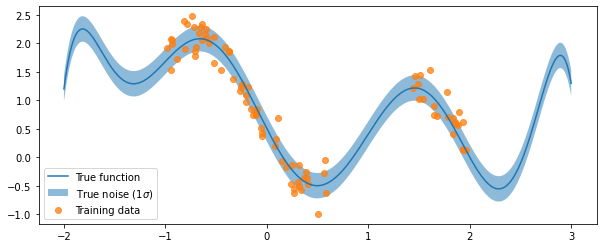

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

x_tmp = np.linspace(-2, 3, 1000)
ax.plot(x_tmp, f(x_tmp), label='True function')
ax.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True noise (1$\sigma$)')
ax.scatter(x, y, alpha=0.75, label='Training data')
ax.legend()
plt.show()

## Using a baseline non-Bayesian model

To see what we can expect from the model, we first check a non-Bayesian variant with the same architecture. The only difference is that this non-Bayesian version uses regular linear layers instead of WHVI linear layers. We expect that this model will be able to approximate the function quite closely.

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from activations import Cosine

non_bayesian_model = nn.Sequential(
    nn.Linear(1, 128, bias=False),
    Cosine(),
    nn.Linear(128, 128, bias=False),
    Cosine(),
    nn.Linear(128, 1, bias=False)
)

optimizer = optim.Adam(non_bayesian_model.parameters(), lr=lambda0)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t) ** (-p))
for epoch in tqdm(range(5000)):
    for batch_index, (data_x, data_y) in enumerate(data_loader):
        loss = F.mse_loss(non_bayesian_model(data_x), data_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        non_bayesian_model.zero_grad(set_to_none=True)

100%|██████████| 5000/5000 [00:07<00:00, 641.45it/s]


The plot below indicates a poor fit to the data. This suggests that the Bayesian version of this model will not be good, because it will be even more difficult to fit it using ELBO as an approximation to the unknown criterion function. This does indeed turn out to be the case.

A reason could be that cosine is an inappropriate activation function, since our actual underlying function is a polynomial, whereas the authors could have used some function of cosine.

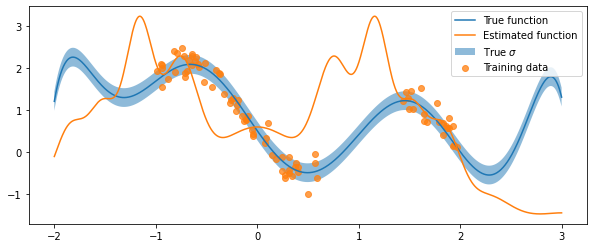

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))

x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = non_bayesian_model(x_test).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred, label='Estimated function')
plt.scatter(x, y, alpha=0.75, label='Training data')
plt.legend(loc='upper right')
plt.show()

We repeat our experiment using the sigmoid activation instead of cosine.

In [6]:
non_bayesian_model = nn.Sequential(
    nn.Linear(1, 128, bias=False),
    nn.Sigmoid(),
    nn.Linear(128, 128, bias=False),
    nn.Sigmoid(),
    nn.Linear(128, 1, bias=False)
)

optimizer = optim.Adam(non_bayesian_model.parameters(), lr=lambda0)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t) ** (-p))
for epoch in tqdm(range(5000)):
    for batch_index, (data_x, data_y) in enumerate(data_loader):
        loss = F.mse_loss(non_bayesian_model(data_x), data_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        non_bayesian_model.zero_grad(set_to_none=True)

100%|██████████| 5000/5000 [00:08<00:00, 611.27it/s]


The plot below shows that sigmoid is a more suitable activation by comparison. For this reason, the next WHVI experiments will be based on the sigmoid activation function.

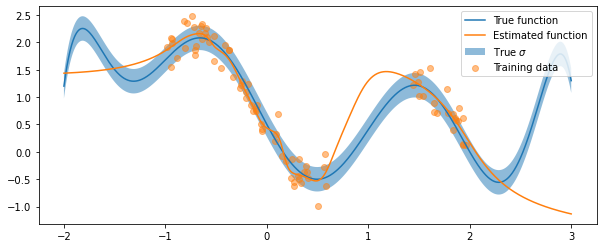

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))

x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = non_bayesian_model(x_test).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred, label='Estimated function')
plt.scatter(x, y, alpha=0.5, label='Training data')
plt.legend(loc='upper right')
plt.show()

## Using the WHVI model

We first check that our model with WHVI layers achieves a good fit without the KL term. We expect the fit to be similar to the non-Bayesian variant, but slightly worse due to sampling and not pure optimization.

In [8]:
from networks import WHVIRegression
from layers import WHVILinear

model = WHVIRegression([
    WHVILinear(1, 128, device=device),
    nn.Sigmoid(),
    WHVILinear(128, 128, device=device),
    nn.Sigmoid(),
    WHVILinear(128, 1, device=device)
])
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lambda0)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t) ** (-p))

In [9]:
model.train_model(data_loader, optimizer, scheduler, epochs1=500, epochs2=5000, ignore_kl=True)

[Opt. var.] KL = 1790194.38, MNLL = 52.81: 100%|██████████| 5000/5000 [00:23<00:00, 214.17it/s]       


In [10]:
x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = model(x_test)

y_pred_mu = y_pred.mean(dim=2).detach().numpy().ravel()
y_pred_sd = y_pred.std(dim=2).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

The model achieves a decent fit in comparison to the previous non-Bayesian experiments, as can be seen on the plot below.

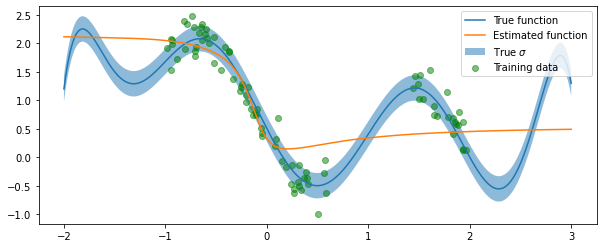

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred_mu, label='Estimated function')
plt.scatter(x, y, alpha=0.5, label='Training data', color='green')
plt.legend(loc='upper right')
plt.show()

We now repeat the experiment by also using the KL divergence term.

In [ ]:
model = WHVIRegression([
    WHVILinear(1, 128, device=device, lambda_=15.0),
    nn.Sigmoid(),
    WHVILinear(128, 128, device=device, lambda_=5.0),
    nn.Sigmoid(),
    WHVILinear(128, 1, device=device, lambda_=1e-5)
])
optimizer = optim.Adam(model.parameters(), lr=lambda0)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t) ** (-p))

model.train_model(data_loader, optimizer, scheduler, epochs1=500, epochs2=150000, ignore_kl=False)

[Opt. var.] KL = 28881.08, MNLL = 126.89:   4%|▎         | 5537/150000 [00:27<11:48, 203.83it/s]       

In [ ]:
x_test = torch.tensor(np.linspace(-2, 3, 1000).reshape(-1, 1).astype(np.float32))
y_test = torch.tensor(f(np.linspace(-2, 3, 1000)).reshape(-1, 1).astype(np.float32))
y_pred = model(x_test)

y_pred_mu = y_pred.mean(dim=2).detach().numpy().ravel()
y_pred_sd = y_pred.std(dim=2).detach().numpy().ravel()
x_test = x_test.detach().numpy().ravel()

quantiles = torch.stack([torch.quantile(y_pred[i, ...], torch.tensor([0.05, 0.95, 0.25, 0.75])) for i in range(y_pred.size()[0])]).detach().numpy()

This fit heavily relies on the chosen prior covariances.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

x_tmp = np.linspace(-2, 3, 1000)
plt.plot(x_tmp, f(x_tmp), label='True function')
# plt.fill_between(x_tmp, f(x_tmp) + np.sqrt(np.exp(-3)), f(x_tmp) - np.sqrt(np.exp(-3)), alpha=0.5, label='True $\sigma$')
plt.plot(x_test, y_pred_mu, label='Estimated function')
# q25 - q75
plt.fill_between(x_test, quantiles[:, 2], quantiles[:, 3], label='q25 - q75', alpha=0.5, color='orange')
# q5 - q95
plt.fill_between(x_test, quantiles[:, 0], quantiles[:, 1], label='q5 - q95', alpha=0.25, color='orange')
plt.scatter(x, y, alpha=0.5, label='Training data', color='green')
plt.legend(loc='upper right')
plt.show()

We inspect the number of parameters in our model. The authors report 1541 parameters for this example, but we only have 1537. What are the four missing parameters?

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params